At first we will generate 1000 example with 2D features with normal distribution error

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def generate_data(w, b, num_samples=1000, noise=0.01):
    """Generate synthetic regression data"""
    X = torch.randn(num_samples, len(w))
    noise_term = torch.randn(num_samples, 1) * noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise_term
    return X, y

In [3]:
w_true = torch.tensor([2.0, -3.4 ])
b_true = 4.2

X_train, y_train = generate_data(w_true, b_true, num_samples=1000)
X_test, y_test = generate_data(w_true, b_true, num_samples=200)

We will use pytorch standard Dataloader to load the patches

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
X_batch, y_batch = next(iter(train_loader))
print(X_batch.shape)  # torch.Size([32, 3])
print(y_batch.shape)

torch.Size([32, 2])
torch.Size([32, 1])


In [54]:
class LinearRegression(torch.nn.Module):
    def __init__(self, num_inputs, lr, sigma = 0.01):
        super().__init__()
        
        self.w = torch.nn.Parameter(torch.normal(0, sigma, (num_inputs, 1), requires_grad=True))
        self.b = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
        self.lr = lr
        
    def forward(self, X):
        return torch.matmul(X,self.w) + self.b
    
    def loss(self, y_hat, y):
        fn = torch.nn.HuberLoss()
        return fn(y_hat,y)
    
    def configure_optimizer(self):
        return torch.optim.SGD([self.w,self.b], self.lr)

In [55]:
model = LinearRegression(num_inputs=2, lr = 0.03 )
optimizer = model.configure_optimizer()

In [56]:
epochs = 10 
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0 
    
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = model.loss(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation
    model.eval()
    epoch_test_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = model.loss(y_pred, y_batch)
            epoch_test_loss += loss.item()
    
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

# 5. Check learned parameters
print("\n" + "="*50)
print("True parameters:")
print(f"w_true = {w_true}")
print(f"b_true = {b_true}")
print("\nLearned parameters:")
print(f"w_learned = {model.w.data.squeeze()}")
print(f"b_learned = {model.b.data.item():.4f}")

Epoch   0 | Train Loss: 3.866449 | Test Loss: 3.466694

True parameters:
w_true = tensor([ 2.0000, -3.4000])
b_true = 4.2

Learned parameters:
w_learned = tensor([ 1.9755, -3.3731])
b_learned = 4.1790


You can see that this version loss lowered very very quickly compared to the Pytorch course one and that's because we used quadratic for the loss

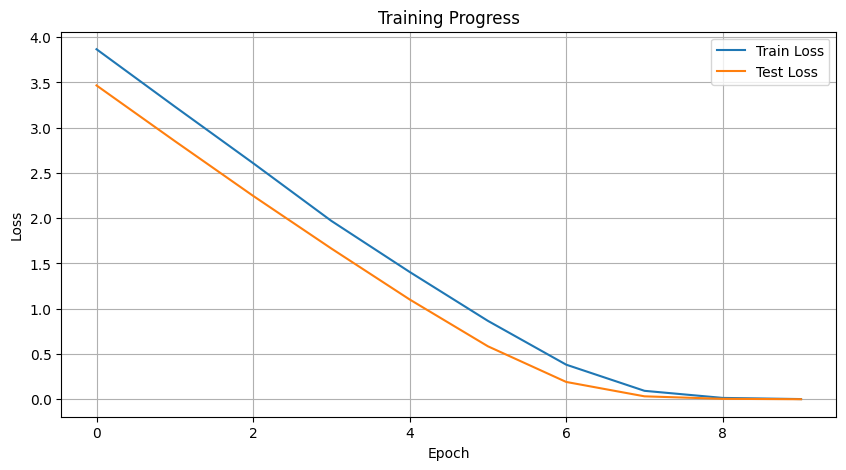

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()